In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Paths
base_dir = '/content/drive/MyDrive/split_dataset'  # Adjusted path
checkpoint_path = '/content/drive/MyDrive/best_modelb3.pth'
resume_checkpoint_path = '/content/drive/MyDrive/resume_checkpoint.pth'

# Class names (match your folder names in split_dataset)
class_names = ['dyslexic', 'normal']


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
train_dir = f"{base_dir}/train"
val_dir = f"{base_dir}/val"
test_dir = f"{base_dir}/test"

In [5]:
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_transforms = transforms.Compose([
    transforms.Resize((320, 320)),   # a bit larger before random crop
    transforms.RandomResizedCrop(300, scale=(0.8, 1.0)),  # target size = 300
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((300, 300)),   # direct resize to match B3
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Datasets ---
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(root=val_dir, transform=test_transforms)
test_dataset  = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# --- DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# --- Info ---
class_names = train_dataset.classes
print("Classes:", class_names)
print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))
print("Test samples:", len(test_dataset))


Classes: ['dyslexic', 'normal']
Training samples: 7042
Validation samples: 1509
Test samples: 1509


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Load pretrained EfficientNet-B3
model = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT)

# Freeze all layers
for param in model.features.parameters():
    param.requires_grad = False

# Replace classifier for binary classification (2 classes)
num_ftrs = model.classifier[1].in_features  # EfficientNet has Sequential classifier
model.classifier[1] = nn.Linear(num_ftrs, 2)  # 2 classes: dyslexic / normal

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [7]:
def train_model(model, train_loader, val_loader, epochs=15, patience=5, resume=True):
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    if resume:
        start_epoch, best_acc, history = load_checkpoint(resume_checkpoint_path, model, optimizer, scheduler)
        best_epoch = start_epoch - 1 if start_epoch > 0 else 0
        epochs_no_improve = 0
        print(f"✅ Resumed from checkpoint at epoch {start_epoch} with best val acc {best_acc:.4f}")
    else:
        start_epoch, best_acc = 0, 0.0
        history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
        epochs_no_improve, best_epoch = 0, 0

    for epoch in range(start_epoch, epochs):
        print(f'\n🔁 Epoch {epoch+1}/{epochs}')
        print('-' * 30)

        model.train()
        train_loss, correct, total = 0.0, 0, 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if batch_idx % 10 == 0:
                print(f'  🧪 Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        epoch_train_loss = train_loss / len(train_loader)
        epoch_train_acc = correct / total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_correct / val_total

        # --- Metrics Tracking ---
        history['train_loss'].append(epoch_train_loss)
        history['val_loss'].append(epoch_val_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_acc'].append(epoch_val_acc)

        print(f'📊 Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f}')
        print(f'📈 Val   Loss: {epoch_val_loss:.4f} | Val   Acc: {epoch_val_acc:.4f}')

        # --- Checkpoint Handling ---
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_epoch = epoch
            epochs_no_improve = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f'✅ New best model saved (Val Acc: {best_acc:.4f})')
        else:
            epochs_no_improve += 1

        save_checkpoint(model, optimizer, scheduler, epoch, best_acc, history, resume_checkpoint_path)

        if epochs_no_improve >= patience:
            print(f'⏹️ Early stopping after {patience} epochs without improvement.')
            break

         # --- Optional: unfreeze EfficientNet-B3 features after 5 epochs ---
        if epoch == 5 and start_epoch <= 5:
            print("🔓 Unfreezing EfficientNet-B3 features for fine-tuning...")
            for param in model.features.parameters():
                param.requires_grad = True

            # Reinitialize optimizer with a lower LR for all trainable params
            optimizer = torch.optim.Adam(
                filter(lambda p: p.requires_grad, model.parameters()),
                lr=1e-5   # smaller LR to avoid destroying pretrained weights
            )
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


    print(f'\n🏁 Training completed. Best Val Acc: {best_acc:.4f} at epoch {best_epoch + 1}')

    if os.path.exists(resume_checkpoint_path):
        os.remove(resume_checkpoint_path)
        print("🧹 Resume checkpoint cleaned up")

    return history


In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

def plot_training_history(history):
    """Plot loss and accuracy from training history dictionary."""
    if not history or len(history['train_loss']) == 0:
        print("⚠️ No history data to plot.")
        return

    clear_output(wait=True)  # Clears cell outputs for cleaner plots

    epochs = len(history['train_loss'])
    x = list(range(1, epochs + 1))

    plt.figure(figsize=(14, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(x, history['train_loss'], label='Train Loss', marker='o', color='orange')
    plt.plot(x, history['val_loss'], label='Val Loss', marker='o', color='blue')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # --- Accuracy Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(x, history['train_acc'], label='Train Accuracy', marker='o', color='green')
    plt.plot(x, history['val_acc'], label='Val Accuracy', marker='o', color='red')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [9]:
checkpoint_path = '/content/best_modelb3.pth'
resume_checkpoint_path = '/content/resume_checkpoint.pth'
EPOCHS = 15


In [10]:
# Function to save complete checkpoint
def save_checkpoint(model, optimizer, scheduler, epoch, best_acc, history, filepath):
    """Save complete training state"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_acc': best_acc,
        'history': history
    }
    torch.save(checkpoint, filepath)
    print(f"💾 Checkpoint saved at epoch {epoch + 1}")

# Function to load checkpoint
def load_checkpoint(filepath, model, optimizer, scheduler):
    """Load complete training state"""
    if os.path.exists(filepath):
        print(f"📂 Loading checkpoint from {filepath}")
        checkpoint = torch.load(filepath, map_location=device)

        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

        start_epoch = checkpoint['epoch'] + 1
        best_acc = checkpoint['best_acc']
        history = checkpoint['history']

        print(f"🔁 Resuming from epoch {start_epoch} | Best Val Acc: {best_acc:.4f}")
        return start_epoch, best_acc, history
    else:
        print("⚠️ No checkpoint found, starting from scratch")
        return 0, 0.0, {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}


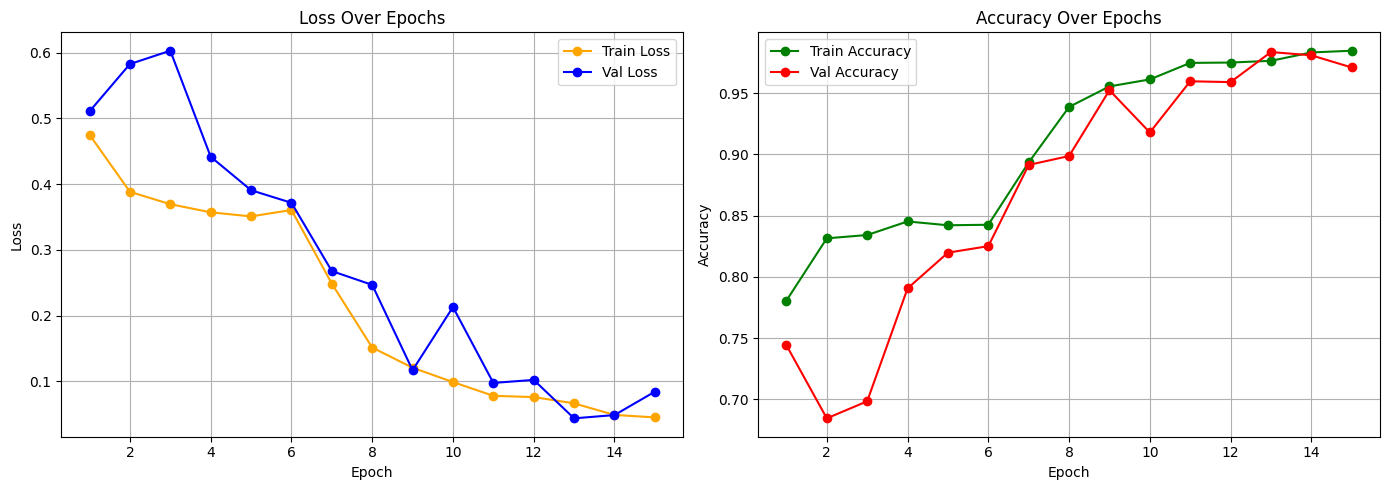

In [11]:
print("Starting training...")
print("Note: Training will automatically resume from the last checkpoint if available")

history = train_model(model, train_loader, val_loader, epochs=EPOCHS, patience=7, resume=True)
plot_training_history(history)


In [12]:
import os
resume_checkpoint_path = "/content/resume_checkpoint.pth"
if os.path.exists(resume_checkpoint_path):
    os.remove(resume_checkpoint_path)
    print("🗑️ Deleted old checkpoint to avoid optimizer mismatch error.")


In [18]:
import torch

def evaluate_test_accuracy(model, test_loader, device):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_acc = correct / total
    print(f"\n🎯 Final Test Accuracy: {test_acc:.4f}")
    return test_acc

# Usage
test_acc = evaluate_test_accuracy(model, test_loader, device)


KeyboardInterrupt: 

In [14]:
final_train_acc = history['train_acc'][-1] * 100
final_val_acc = history['val_acc'][-1] * 100

print(f"\n✅ Final Training Accuracy: {final_train_acc:.2f}%")
print(f"✅ Final Validation Accuracy: {final_val_acc:.2f}%")



✅ Final Training Accuracy: 98.45%
✅ Final Validation Accuracy: 97.08%


In [19]:
# Load your trained model weights
model.load_state_dict(torch.load("/content/drive/MyDrive/final_modelb3.pth", map_location=device))

# Put model in eval mode (important for dropout/batchnorm)
model.eval()

# Now run test evaluation
test_acc = evaluate_test_accuracy(model, test_loader, device)



🎯 Final Test Accuracy: 0.9755


In [15]:
import torch

# Save trained model weights
save_path = "/content/drive/MyDrive/final_modelb3.pth"
torch.save(model.state_dict(), save_path)

print(f"✅ Model saved at: {save_path}")


✅ Model saved at: /content/drive/MyDrive/final_modelb3.pth


In [16]:
from google.colab import files
files.download(save_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


📊 Classification Report:

              precision    recall  f1-score   support

    dyslexic       1.00      0.95      0.97       755
      normal       0.95      1.00      0.98       754

    accuracy                           0.98      1509
   macro avg       0.98      0.98      0.98      1509
weighted avg       0.98      0.98      0.98      1509



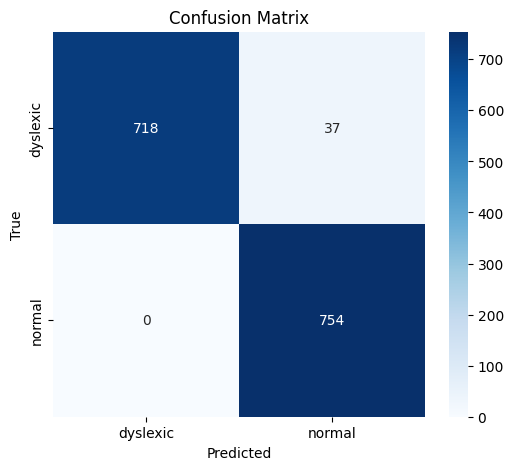

In [20]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("\n📊 Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Usage
class_names = ["dyslexic", "normal"]  # adjust if needed
plot_confusion_matrix(model, test_loader, device, class_names)
